In [1]:
-- Gloria Budiman
-- EE569 HW4
-- 6528-1836-50
-- 11/25/2016

require 'nn'
require 'optim'

torch.manualSeed(0)
torch.setnumthreads(4)

In [2]:
function setup(trelu_threshold) 
    classes = { 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 }
    geometry = { 32, 32 }

    net = nn.Sequential()

    net:add(nn.SpatialConvolution(1, 6, 5, 5))
    net:add(nn.AddConstant(trelu_threshold))
    net:add(nn.ReLU())
    net:add(nn.AddConstant(-trelu_threshold))
    net:add(nn.SpatialMaxPooling(2, 2, 2, 2))

    net:add(nn.SpatialConvolution(6, 16, 5, 5))
    net:add(nn.AddConstant(trelu_threshold))
    net:add(nn.ReLU())
    net:add(nn.AddConstant(-trelu_threshold))
    net:add(nn.SpatialMaxPooling(2, 2, 2, 2))

    net:add(nn.View(16*5*5))
    net:add(nn.Linear(16*5*5, 120))
    net:add(nn.AddConstant(trelu_threshold))
    net:add(nn.ReLU())
    net:add(nn.AddConstant(-trelu_threshold))
    net:add(nn.Linear(120, 84))
    net:add(nn.AddConstant(trelu_threshold))
    net:add(nn.ReLU())
    net:add(nn.AddConstant(-trelu_threshold))
    net:add(nn.Linear(84, #classes))
    net:add(nn.LogSoftMax())
    
    parameters, gradParameters = net:getParameters()
    criterion = nn.ClassNLLCriterion()
    confusion = optim.ConfusionMatrix(classes)
end

In [3]:
function normalize(input, n_channels)
    local mean = {}
    local stdev = {}
    
    for channel = 1, n_channels do
        mean[channel] = input.data[{ {}, {channel}, {}, {} }]:mean()
        stdev[channel] = input.data[{ {}, {channel}, {}, {} }]:std()
        
        print('Channel ' .. channel .. ' mean: ' .. mean[channel] .. ' stdev: ' .. stdev[channel])
        
        input.data[{ {}, {channel}, {}, {} }]:add(-mean[channel])
        input.data[{ {}, {channel}, {}, {} }]:div(stdev[channel])
    end
end

In [4]:
function load_data()    
    train = torch.load('mnist-p1b-train.t7')
    test = torch.load('mnist-p1b-test.t7')
    
    n_train = train.data:size()[1]
    n_test = test.data:size()[1]
    
    train.data = train.data:double()
    test.data = test.data:double()
end

In [5]:
function exec_training(obj, n_channels, current_epoch) 
    confusion:zero()
    
    for t = 1, n_train, batch_size do
        local limit = math.min(t + batch_size - 1, n_train)
        
        local limited_batch_size = limit - t + 1
        local inputs = torch.Tensor(limited_batch_size, n_channels, geometry[1], geometry[2])
        local targets = torch.Tensor(limited_batch_size)
        local k = 1
        
        for i = t, limit do
            local input = obj.data[i]:clone()
            local target = obj.label[i]
            
            inputs[k] = input
            targets[k] = target
            k = k + 1
        end
        
        local feval = function(x)
            collectgarbage()
            
            if x ~= parameters then
                parameters:copy(x)
            end
            gradParameters:zero()
            
            local outputs = net:forward(inputs)
            local f = criterion:forward(outputs, targets)
            local df_do = criterion:backward(outputs, targets)
            net:backward(inputs, df_do)
            
            for i = 1, limited_batch_size do
                confusion:add(outputs[i], targets[i])
            end
            
            return f, gradParameters
        end
        
        sgd_state = sgd_state or {
            learningRate = 0.03,
            learningRateDecay = 1e-7,
            momentum = 0.5
        }
        optim.sgd(feval, parameters, sgd_state)
    end
    
    confusion:updateValids()
    return confusion.averageValid
end

In [6]:
function exec_testing(obj, n_channels, current_epoch)
    confusion:zero()
    
    for t = 1, n_test, batch_size do
        local limit = math.min(t + batch_size - 1, n_test)
        
        local limited_batch_size = limit - t + 1
        local inputs = torch.Tensor(limited_batch_size, n_channels, geometry[1], geometry[2])
        local targets = torch.Tensor(limited_batch_size)
        local k = 1
        
        for i = t, limit do
            local input = obj.data[i]:clone()
            local target = obj.label[i]
            
            inputs[k] = input
            targets[k] = target
            k = k + 1
        end
        
        local preds = net:forward(inputs)
        
        for i = 1, limited_batch_size do
            confusion:add(preds[i], targets[i])
        end
    end 
    
    confusion:updateValids()
    return confusion.averageValid
end

In [7]:
setup(0.5)
load_data()
normalize(train, 1)
normalize(test, 1)

n_epoch = 32
batch_size = 256
local last_train_conf
local last_test_conf
for epoch = 1, n_epoch do
    local acc_train = exec_training(train, 1, epoch)
    
    if (epoch == n_epoch) then
        last_train_conf = confusion:__tostring__()
    end
    
    local acc_test = exec_testing(test, 1, epoch)
    
    if (epoch == n_epoch) then
        last_test_conf = confusion:__tostring__()
    end
    
    io.write(string.format('Epoch %3d: %.4f%% | %.4f%%\n', epoch, acc_train * 100, acc_test * 100))
end

print(last_train_conf)
print(last_test_conf)

Channel 1 mean: 25.509416422526 stdev: 70.180423838273	


Channel 1 mean: 25.87140625 stdev: 70.739298703524	


Epoch   1: 77.0967% | 90.9369%


Epoch   2: 94.0817% | 95.5838%


Epoch   3: 96.0277% | 96.7766%


Epoch   4: 96.8258% | 97.3623%


Epoch   5: 97.3252% | 97.6023%


Epoch   6: 97.6280% | 97.6840%


Epoch   7: 97.8710% | 97.8748%


Epoch   8: 98.0965% | 98.0656%


Epoch   9: 98.2301% | 98.1575%


Epoch  10: 98.3806% | 98.3591%


Epoch  11: 98.4849% | 98.3794%


Epoch  12: 98.5977% | 98.4501%


Epoch  13: 98.7079% | 98.5104%


Epoch  14: 98.8036% | 98.5395%


Epoch  15: 98.8785% | 98.5162%


Epoch  16: 98.9461% | 98.5465%


Epoch  17: 99.0193% | 98.5947%


Epoch  18: 99.0648% | 98.6242%


Epoch  19: 99.1357% | 98.6830%


Epoch  20: 99.1837% | 98.7021%


Epoch  21: 99.2295% | 98.7343%


Epoch  22: 99.2827% | 98.7547%


Epoch  23: 99.3245% | 98.7961%


Epoch  24: 99.3746% | 98.7644%


Epoch  25: 99.4132% | 98.7760%


Epoch  26: 99.4560% | 98.7760%


Epoch  27: 99.4966% | 98.7773%


Epoch  28: 99.5272% | 98.7766%


Epoch  29: 99.5557% | 98.7666%


Epoch  30: 99.5858% | 98.7763%


Epoch  31: 99.6127% | 98.8075%


Epoch  32: 99.6565% | 98.7975%
ConfusionMatrix:
[[    5918       0       1       0       1       0       1       0       1       1]   99.916% 	[class: 1]
 [       0    6730       1       0       1       1       1       6       2       0]   99.822% 	[class: 2]
 [       2       2    5942       2       1       0       0       5       3       1]   99.731% 	[class: 3]
 [       0       1       4    6108       0       7       0       4       5       2]   99.625% 	[class: 4]
 [       0       2       0       0    5822       0       4       1       1      12]   99.658% 	[class: 5]
 [       1       1       0       4       0    5401      10       0       2       2]   99.631% 	[class: 6]
 [       5       1       1       0       1       3    5905       0       2       0]   99.780% 	[class: 7]
 [       0       8       5       3       3       0       0    6237       3       6]   99.553% 	[class: 8]
 [       1       5       4       4       1       5       2       3    5821       5]   99.487% 	[class: 9

In [115]:
function top_n(_a, _n)
    local a = _a:clone()
    local top_results = {}
    
    --print(a)
    for n = 1, _n do
        local max_index = top_one(a)
        top_results[n] = max_index
        --print(a)
    end
    
    return top_results
end

In [116]:
function top_one(a)
    local max = -999
    local max_index = -1
    
    for i = 1, 10 do
        if a[i] > max then
            max = a[i]
            max_index = i
        end
    end
    
    --print('Chopped index', max_index)
    a[max_index] = -999
    
    return max_index
end

In [140]:
function process_errors(e)
--     for k, v in pairs(e) do
--         itorch.image(test.data[k])
--         local probs = ''
--         for _junk, val in pairs(v.probabilities) do
--             probs = probs .. (val - 1) .. ' '
--         end
--         print(v.expectation - 1, ' | ', probs)
--     end
    --for expectation, e_data in pairs(e) do
    for expectation = 1, 10 do
        local e_data = e[expectation]
        print('#####################')
        print('Expecting ', expectation - 1)
        print('#####################')
        
        for index, probs in pairs(e_data) do
            itorch.image(test.data[index])
            
            local ps = '';
            for _junk, val in pairs(probs) do
                ps = ps .. (val - 1) .. ' '
            end
            print(ps)
        end
    end
end

#####################	
Expecting 	0	
#####################	


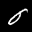

8 0 5 	


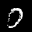

9 0 7 	


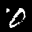

8 1 0 	
#####################	
Expecting 	1	
#####################	


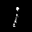

7 1 2 	


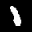

8 1 3 	


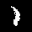

8 1 2 	


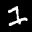

2 1 7 	


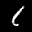

8 1 6 	


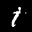

8 1 2 	


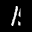

8 2 1 	
#####################	
Expecting 	2	
#####################	


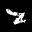

7 2 1 	


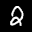

8 2 0 	


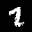

1 7 2 	


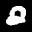

0 8 2 	


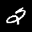

8 2 5 	


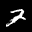

7 2 8 	
#####################	
Expecting 	3	
#####################	


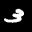

5 3 9 	


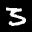

5 3 9 	


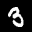

8 9 3 	


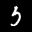

5 3 9 	


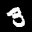

8 3 9 	


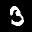

9 3 5 	


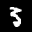

5 3 8 	


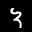

9 7 8 	
#####################	
Expecting 	4	
#####################	


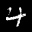

7 4 2 	


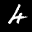

6 4 2 	


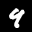

9 4 8 	


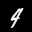

9 4 7 	


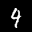

9 4 7 	


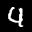

9 4 0 	


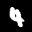

9 3 4 	


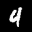

9 4 8 	


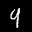

9 4 8 	


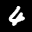

6 4 0 	


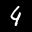

9 4 8 	


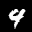

9 4 8 	


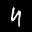

9 4 8 	


9 4 7 	


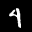

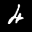

2 4 6 	
#####################	
Expecting 	5	
#####################	


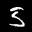

3 5 8 	


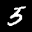

3 5 8 	


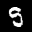

9 5 3 	


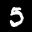

3 5 9 	


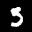

3 9 5 	


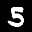

3 5 8 	


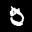

0 5 9 	


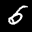

6 5 0 	


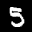

3 5 9 	


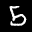

8 5 6 	


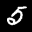

0 5 6 	


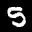

9 5 3 	


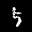

3 5 9 	


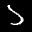

3 5 8 	


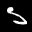

1 5 7 	


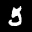

3 5 9 	


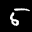

6 5 0 	


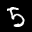

3 5 8 	


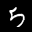

3 5 9 	
#####################	
Expecting 	6	
#####################	


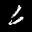

3 6 5 	


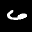

4 2 6 	


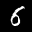

5 6 8 	


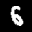

5 6 8 	


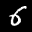

5 6 8 	


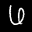

0 6 5 	


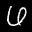

0 6 5 	


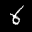

8 6 5 	


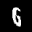

8 6 5 	


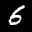

5 6 8 	


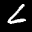

2 4 6 	


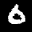

0 6 5 	


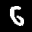

5 6 8 	


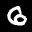

0 6 2 	


0 6 5 	


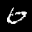

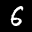

5 6 8 	


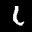

1 2 4 	


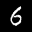

5 6 8 	


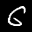

2 6 0 	


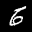

5 6 8 	


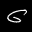

5 0 2 	
#####################	
Expecting 	7	
#####################	


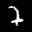

2 7 1 	


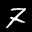

2 7 8 	


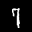

9 7 1 	


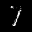

1 7 4 	


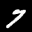

9 7 4 	


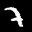

3 2 7 	


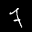

1 2 7 	


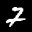

2 7 3 	


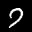

9 7 0 	


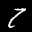

8 7 3 	


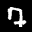

0 7 9 	


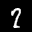

8 2 7 	


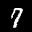

8 7 9 	


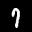

9 7 1 	
#####################	
Expecting 	8	
#####################	


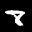

7 2 8 	


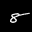

5 6 8 	


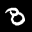

3 0 2 	


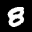

0 8 9 	


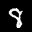

9 8 7 	


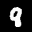

9 8 3 	


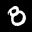

0 9 8 	


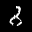

2 8 3 	


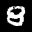

9 8 0 	


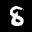

5 8 6 	


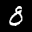

0 3 8 	
#####################	
Expecting 	9	
#####################	


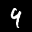

4 9 8 	


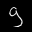

5 3 9 	


1 9 8 	


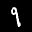

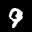

7 9 0 	


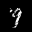

7 9 4 	


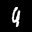

4 9 8 	


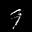

7 9 2 	


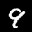

8 9 4 	


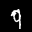

3 7 9 	


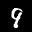

8 9 4 	


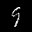

5 9 8 	


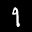

1 9 4 	


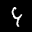

4 9 8 	


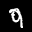

3 9 2 	


In [141]:
local limit = n_test
local errors = {}

for t = 1, limit do
    local probs = top_n(net:forward(test.data[t]), 3)
    local expectation = test.label[t]

    if (probs[1] ~= expectation) then
        if errors[expectation] == nil then
            errors[expectation] = {}
        end
        
        errors[expectation][t] = probs
    end
end

process_errors(errors)